# Практическая работа 2.1. Анализ данных с помощью DASK

**Вариант 5**

UK Property Price official data 1995-202304.zip.

**Задание.**

`2.1.1.` Настроить среду и рабочий каталог.

`2.1.2.` Загрузить данные.

`2.1.3.` Проверить качество данных (например, отсутствующие значения и выбросы).

`2.1.4.` Удалить столбцы (множество пропусков в значениях, бесполезные столбцы для анализа).

`2.1.1.` **Настроить среду и рабочий каталог.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ls

drive/  sample_data/


In [4]:
!pip install "dask[complete]"

In [5]:
# import libraries
import sys
import os

## import dask libraries
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# import libraries
import pandas as pd

In [6]:
cwd = os.getcwd()

# print
print('', sys.executable)
print('', cwd)

 /usr/bin/python3
 /content


`2.1.2.` **Загрузить данные.**

In [7]:
from google.colab import files
files.upload()

{}

In [8]:
cd drive/MyDrive/

/content/drive/MyDrive


In [19]:
## read data using DataFrame API
df = dd.read_csv('202304.csv',dtype={'31': 'object',
       'Unnamed: 8': 'object'} )
df

,{F887F88E-7D15-4415-804E-52EAC2F10958},70000,1995-07-07 00:00,MK15 9HP,D,N,F,31,Unnamed: 8,ALDRICH DRIVE,WILLEN,MILTON KEYNES,MILTON KEYNES.1,MILTON KEYNES.2,A,A.1
npartitions=77,,,,,,,,,,,,,,,,
,string,int64,string,string,string,string,string,string,string,string,string,string,string,string,string,string
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Обратите внимание, что

- `metadata` отображаются в кадре вместо образца данных
синтаксис очень похож на API Pandas.

- `# partitions` — это количество разбиений, используемых для разделения основного набора данных. Оптимальное количество определяется планировщиком, который разделяет `DataFrame Pandas` на более мелкие фрагменты. В этом случае размер каждого раздела составляет ~64 МБ (т. е. размер набора данных/npartitions = 2 ГБ/33). Если у нас есть один рабочий процесс, Dask будет переключаться на каждый раздел по одному.

- `data types` сообщаются под каждым именем столбца (аналогично описанию метода в Pandas, однако выполняется путем случайной выборки, поскольку данные разбросаны по нескольким физическим машинам). Хорошей практикой является явное определение типов данных вместо того, чтобы полагаться на вывод Dask (в идеале хранить в двоичном формате).

- `Dask Name` сообщает имя группы обеспечения доступности баз данных (т.е. с задержкой).

- `# tasks` — это количество узлов в группе, которые обеспечивают доступность к данным. Вы можете представить задачу как функцию `Python`, и в этом случае каждая задача выполняет три задачи:

1) чтение необработанных данных,

2) разделение данных на соответствующие блоки,

3) инициализация объекта `DataFrame`.

`2.1.3.` **Проверить качество данных (например, отсутствующие значения и выбросы).**

In [20]:
# count missing values
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
1995-07-07 00:00                          int64
{F887F88E-7D15-4415-804E-52EAC2F10958}      ...
Dask Name: sum, 5 expressions
Expr=(~ NotNull(frame=ArrowStringConversion(frame=FromMapProjectable(b252f01)))).sum()

Обратите внимание на то, что:

Созданный объект `dask` представляет собой серию, содержащую метаданные, а синтаксис очень похож на `API Pandas`, обработка еще не завершена, вместо этого `Dask` подготовил `DAG`, сохраненный в переменной пропущенных значений (преимущество быстрого построения графика без необходимости ждать вычислений)

Количество задач увеличилось, поскольку были добавлены `2` задачи (т. е. проверка недостающих значений и суммы) для каждого из `32` разделов, а также окончательное добавление для агрегирования результатов по всем разделам, в общей сложности их - `4`.

In [21]:
# calculate percent missing values
mysize = df.index.size
missing_count = ((missing_values / mysize) * 100)
missing_count

Dask Series Structure:
npartitions=1
1995-07-07 00:00                          float64
{F887F88E-7D15-4415-804E-52EAC2F10958}        ...
Dask Name: mul, 9 expressions
Expr=(~ NotNull(frame=ArrowStringConversion(frame=FromMapProjectable(b252f01)))).sum() / Index(frame=ArrowStringConversion(frame=FromMapProjectable(b252f01))).size() * 100

Обратите внимание на то, что:

- созданный объект `dask` представляет собой серию, и вычисление еще не завершено.

- `df.index.size` — это объект `dask` `dask.dataframe.core.Scalar`. Вы не можете получить доступ к его значению/длине напрямую, как если бы вы это делали со списком (например, `len()`). Это противоречило бы всей идее `dask` (т.е. прочитать весь набор данных).

- `# tasks` количество задач увеличилось, так как были добавлены `2` задачи (т.е. деление и умножение).

-  `data type` изменен с `int64` на `float64`. Dask автоматически преобразовал его, если тип данных на выходе  не совпадает с входным после разделения.

In [23]:
# запуск вычисления, используя метод подсчета
with ProgressBar():
  missing_count_percent = missing_count.compute()
missing_count_percent

[########################################] | 100% Completed | 197.31 s


,0
{F887F88E-7D15-4415-804E-52EAC2F10958},0.000000
70000,0.000000
1995-07-07 00:00,0.000000
MK15 9HP,0.162571
D,0.000000
N,0.000000
F,0.000000
31,0.014815
Unnamed: 8,88.237964
ALDRICH DRIVE,1.583507


Обратите внимание на то, что:

- метод `.compute()` необходим для запуска действий, встроенных в каждый узел группы обеспечения доступности баз данных.

- Результаты метода вычислений сохраняются в серии `Pandas`.

- `ProgressBar()` — это оболочка для отслеживания запущенных задач. Он показывает завершенную работу.

Видим, что не все столбцы являются неполными, и нам следует их удалить.

`2.1.4.` **Удалить столбцы (пропуски в значениях, бесполезные столбцы для анализа).**

In [26]:
# операция фильтрации разреженных столбцов (более 60% пропущенных значений) и сохраняем оставшиеся
columns_to_drop = missing_count_percent[missing_count_percent > 60].index
print(columns_to_drop)

Index(['Unnamed: 8'], dtype='object')


In [29]:
# drop sparse columns
with ProgressBar():
    #df_dropped = df.drop(columns_to_drop, axis=1).persist()
    df_dropped = df.drop(columns=columns_to_drop).compute()

[########################################] | 100% Completed | 194.02 s


Обратите внимание на то, что:

- использовать `Pandas Series` для удаления столбцов в `Dask DataFrame`, поскольку каждый раздел является `Pandas DataFrame`.

- В случае, если серия доступна для всех потоков, в кластере она будет сериализована и широковещательно передана всем рабочим узлам.

- Метод `.persist()` позволяет хранить в памяти промежуточные вычисления, чтобы их можно было использовать повторно.

# Практическая работа 2.2. Визуализация ориентированных ациклических графов (DAG)

- `DASK` использует библиотеку `Graviz` для создания визуального представления групп `DAG`, созданных планировщиком.

- и спользуйте метод `.visualize()` для проверки групп `DAG DataFrames`, `Series`, `Bag` и массивов.

Для упрощения будем использовать объект `Dask Delayed` вместо `DataFrames`, поскольку они становятся довольно большими и их трудно визуализировать.

- `Delayed` — это конструктор, который позволяет обертывать функции и создавать объекты `Dask Delayed`, эквивалентные узлу в `DAG`. Объединяя захваченные объекты, создаем группу доступа к данным.

Ниже приведены два примера: в первом  `DAG` только с одним узлом и зависимостями, а во втором  - `DAG` с несколькими узлами и зависимостями.

**Задание.**

`2.2.1.` Визуализировать `DAG` с одним узлом и зависимостями.

`2.2.1.` Визуализировать `DAG` с более чем одним узлом и зависимостями.



`2.1.1.` **Визуализировать `DAG` с одним узлом и зависимостями.**

In [30]:
# import library
import dask.delayed as delayed

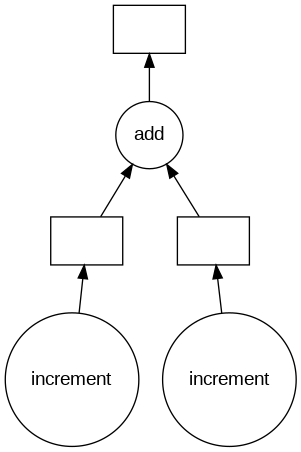

In [31]:
def increment(i):
    return i + 1

def add(x, y):
    return x + y

# функции переноса внутри отложенного объекта и цепочки
x = delayed(increment)(1)
y = delayed(increment)(2)
z = delayed(add)(x, y)

# visualize the DAG
z.visualize()

In [32]:
# show the result
z.compute()

5

Обратите внимание на то, что:

- Чтобы построить узел, в функцию передали захваченный объект, а затем передали аргументы этой функции. Можно использовать декораторы.

- Круги указывают на функцию и вычисления, а квадраты — промежуточный или конечный результат.

- Входящие стрелки представляют зависимости. Функция `increment` не имеет никаких зависимостей, а функция `add` — две. Таким образом, функция `add`  должна ждать, пока не будут вычислены объекты `x` и `y`.

- Функции без зависимостей могут вычисляться независимо, и каждой из них можно назначить `workera`.

- Используйте метод `.visualize()` на последнем узле с зависимостями.

- `Dask` не расчитывает `DAG`. Используйте метод `.compute()` на последнем узле, чтобы увидеть результат.

`2.2.2.` **Визуализировать `DAG` с более чем одним узлом и зависимостями.**

построить более сложную группу `DAG` с двумя уровнями:

- `Layer1` создается путем циклического перебора списка данных  в ​`​dask` . Этот слой объединяет ранее созданное приращение функции со значениями в списке, а затем использует встроенное суммирование функции для объединения результатов;

- `Layer2` построен циклически для каждого объекта, созданного в `Layer1`.

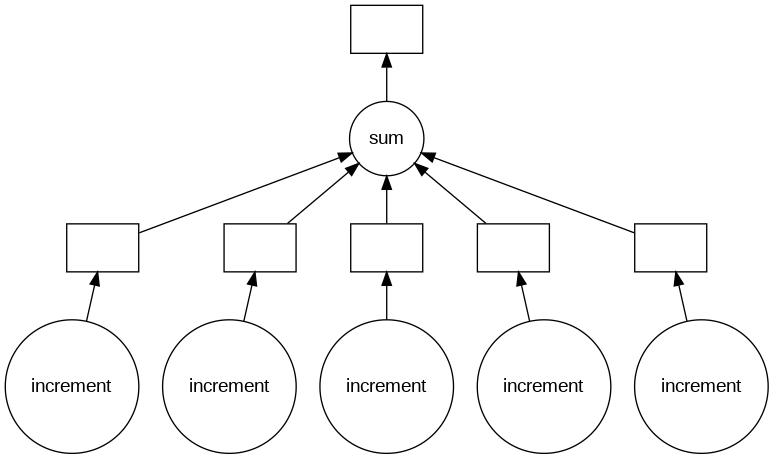

In [33]:
data = [1, 2, 3, 4, 5]

# compile first layer and visualize
layer1 = [delayed(increment)(i) for i in data]
total1 = delayed(sum)(layer1)
total1.visualize()

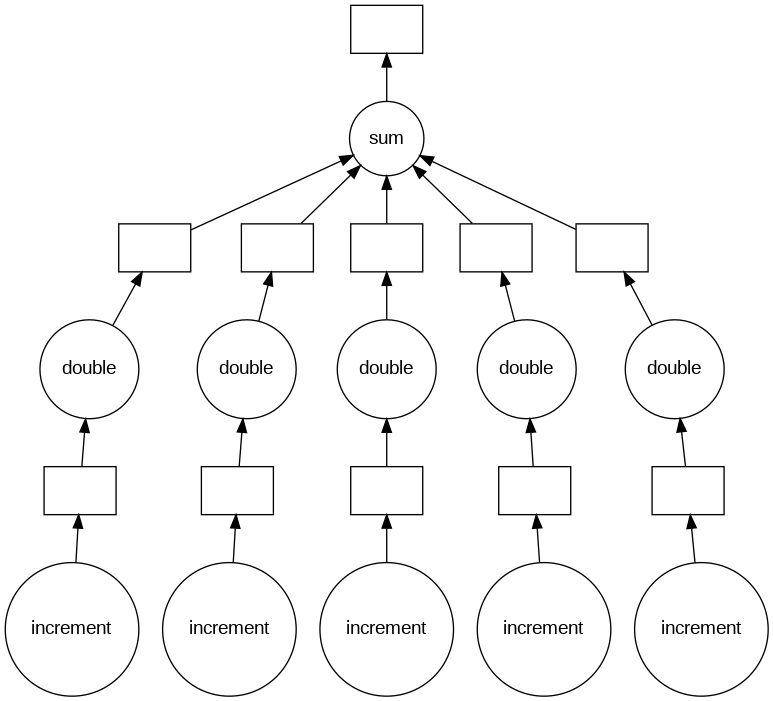

In [34]:
def double(x):
    return x * 2

# compile second layer and visualize
layer2 = [delayed(double)(j) for j in layer1]
total2 = delayed(sum)(layer2)#.persist()
total2.visualize()

In [35]:
z = total2.compute()
z

40

Обратите внимание на то, что:

- построение через использование функции,

- используем `.persist()`, и результат будет представлен на графике в виде прямоугольника.

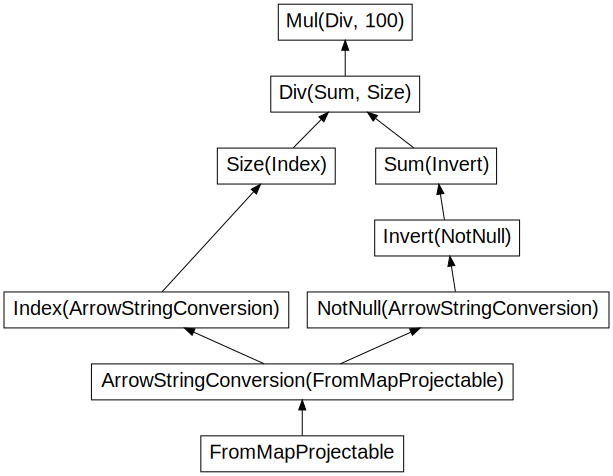

In [36]:
# visualize DAGs built from the DataFrame
missing_count.visualize()